In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
# generating our dataset
image_size = (224, 224)
batch_size = 32

In [3]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2185 files belonging to 15 classes.


In [4]:
val = tf.keras.preprocessing.image_dataset_from_directory(
    "data/valid",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 75 files belonging to 15 classes.


In [5]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(0.5),
        layers.RandomZoom(0.3)
    ]
)

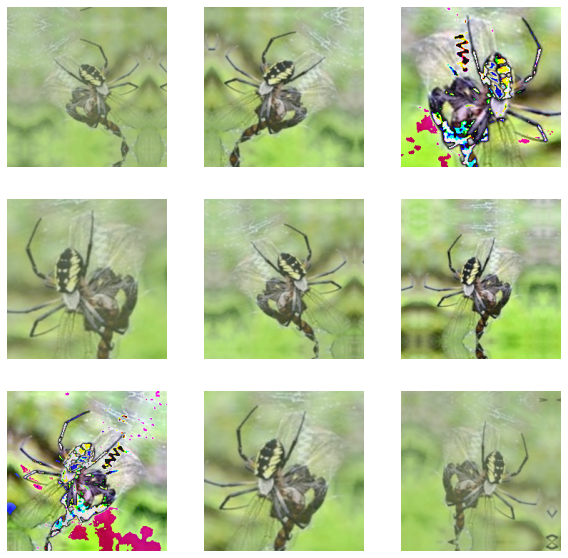

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights='imagenet')

9420800/9406464 [==============================] - 2s 0us/step


In [9]:
image_batch, label_batch = next(iter(train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [10]:
base_model.trainable = False

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(15,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 15)


In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [19]:
inputs = tf.keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = preprocess_input(x)

x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
# x = tf.keras.layers.Dense(128,activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(15)(x)
# outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                           

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
loss0, accuracy0 = model.evaluate(val)

3/3 [==============================] - 3s 565ms/step - loss: 2.9988 - accuracy: 0.0667


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.00
initial accuracy: 0.07


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler 
EarlyStop_callback = EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

In [26]:
EPOCHS = 10
history = model.fit(train,
                    epochs=EPOCHS,
                    validation_data=val,
                   callbacks = [EarlyStop_callback])

Epoch 1/10
69/69 [==============================] - 91s 1s/step - loss: 2.6397 - accuracy: 0.2114 - val_loss: 1.2389 - val_accuracy: 0.7600
Epoch 2/10
69/69 [==============================] - 90s 1s/step - loss: 1.6789 - accuracy: 0.4673 - val_loss: 0.7270 - val_accuracy: 0.8667
Epoch 3/10
69/69 [==============================] - 82s 1s/step - loss: 1.2794 - accuracy: 0.5789 - val_loss: 0.5358 - val_accuracy: 0.9067
Epoch 4/10
69/69 [==============================] - 82s 1s/step - loss: 1.1140 - accuracy: 0.6288 - val_loss: 0.4456 - val_accuracy: 0.9067
Epoch 5/10
69/69 [==============================] - 85s 1s/step - loss: 0.9906 - accuracy: 0.6746 - val_loss: 0.3859 - val_accuracy: 0.9067
Epoch 6/10
69/69 [==============================] - 87s 1s/step - loss: 0.9000 - accuracy: 0.6979 - val_loss: 0.3502 - val_accuracy: 0.9067
Epoch 7/10
69/69 [==============================] - 92s 1s/step - loss: 0.8139 - accuracy: 0.7176 - val_loss: 0.3194 - val_accuracy: 0.9467
Epoch 8/10
69/69 [==

In [66]:
img = keras.preprocessing.image.load_img(
    "data/test/Ladybird Mimic Spider/1.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
score

array([-1.45668   , -1.369254  , -0.11256377, -1.4851608 , -1.5241253 ,
       -0.83155525, -1.2524146 , -1.6810654 ,  1.6861134 , 11.636841  ,
        0.8450039 , -2.585368  ,  1.5528173 , -2.918423  , -0.6632715 ],
      dtype=float32)

In [67]:
import numpy as np

test = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    seed=1337,
    image_size=image_size)

class_names = [
    'Black Widow',
    'Blue Tarantula',
    'Bold Jumper',
    'Brown Grass Spider',
    'Brown Recluse Spider',
    'Deinopis Spider',
    'Golden Orb Weaver',
    'Hobo Spider',
    'Huntsman Spider',
    'Ladybird Mimic Spider',
    'Peacock Spider',
    'Red Knee Tarantula',
    'Spiny-backed Orb-weaver',
    'White Kneed Tarantula',
    'Yellow Garden Spider'
]

Found 75 files belonging to 15 classes.


In [68]:
predictions = []
image_ids = []
for image_batch, label_batch in test:
    batch_predictions = model.predict_on_batch(image_batch)
    batch_predictions = tf.nn.softmax(batch_predictions)
    batch_predictions = batch_predictions.numpy()
    
    class_indices = np.argmax(batch_predictions, axis = 1)
    predicted_class = []
    for index in class_indices:
        predicted_class.append(str(class_names[index]))
    predictions += predicted_class
    
    str_img_ids = []
    for img_id in label_batch:
        str_img_ids.append(class_names[img_id])
    
#     image_ids += label_batch.numpy().tolist()
    image_ids += str_img_ids

In [75]:
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None)
results = pd.DataFrame({'actual': image_ids, 'prediction': predictions})
results

,actual,prediction
0,Ladybird Mimic Spider,Ladybird Mimic Spider
1,Hobo Spider,Hobo Spider
2,Hobo Spider,Hobo Spider
3,Golden Orb Weaver,Golden Orb Weaver
4,Brown Grass Spider,Brown Grass Spider
5,Peacock Spider,Peacock Spider
6,Huntsman Spider,Huntsman Spider
7,Black Widow,Black Widow
8,Deinopis Spider,Deinopis Spider
9,Blue Tarantula,Blue Tarantula


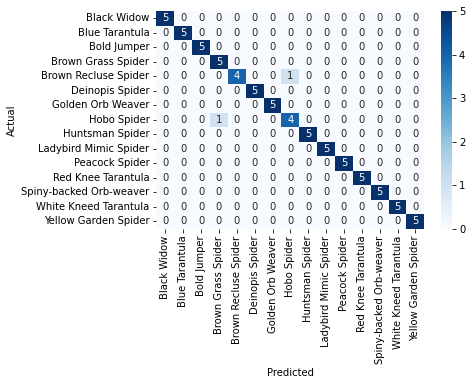

In [82]:
import matplotlib.pyplot as plt
import seaborn as sn

df = pd.DataFrame(results, columns=['actual','prediction'])
confusion_matrix = pd.crosstab(df['actual'], df['prediction'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()